## 课时72 TF2.0版本pix2pix代码(城市街景)
>- **需要注意的是，原始的GAN的生成器网络接收的输入的一个一维的向量，因此整体的生成器网络其实只是一个AutoEncode的Decode部分；而pix2pixGAN的生成器网络部分接收的输入是一个完整的图片，因此pix2pixGAN的生成器网络是一个完整的AutoEncode网络。当我们使用pix2pixGAN网络进行类似图像翻译的任务的时候，输入与输出之间会共享很多的信息，例如图像轮廓信息等。而这个AutoEncode生成器网络在使用普通的卷积网络进行传递的信息传递的时候，每一层网络都要存储这些信息，会很容易出错，因此为了避免这样的情况发生，我们使用U-Net网络来搭建生成器网络。**
>- **pix2pixGAN本质上是一种图像翻译模型。也就是把一张图像翻译成另一张图像。**

In [16]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import warnings
import glob
warnings.filterwarnings("ignore")
tf.__version__

'2.4.0'

### 1. 定义数据集读取和预处理函数


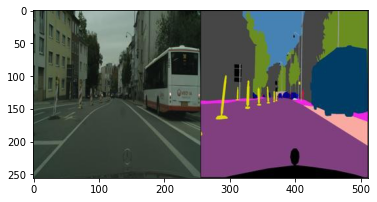

In [17]:
train_images_path = "../../cityscapes_data/cityscapes_data/train/*jpg"
train_images_path_list = glob.glob(pathname=train_images_path)

# 画出一张图像
plt.imshow(tf.keras.preprocessing.image.load_img(train_images_path_list[0]))

In [18]:
# 定义图片解码函数
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

# 定义归一化函数
def normalize(mask, image):
    mask = tf.cast(mask, tf.float32) / 127.5 - 1
    image = tf.cast(image, tf.float32) / 127.5 - 1
    return mask, image

# 定义训练图像加载函数
def load_train_image(image_path):
    image = read_jpg(image_path)
    width = tf.shape(image)[1]
    # 由于image和它对应的mask是合并到一张图片的，因此需要从中间切分开来
    width = width // 2
    input_image = image[:, :width, :]
    input_mask = image[:, width:, :]
    
    # 下面两个resize的操作实际上没有什么实质性的影响，因为mask和image本身就是[256, 256, 3]的
    # 但是下面这两个操作能够使得mask和image在做成datasets之后可以正常显示两个的shape大小
    input_mask = tf.image.resize(input_mask, (256, 256))
    input_image = tf.image.resize(input_image, (256, 256))
    
    if tf.random.uniform(()) > 0.5:
        # 进行翻转时，图像和对应的语义分割图要同时进行翻转
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_mask, input_image = normalize(input_mask, input_image)
    return input_mask, input_image

In [25]:
BATCH_SIZE = 128
BUFFER_SIZE = len(train_images_path_list)

# 创建datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_path_list)
train_dataset = train_dataset.map(load_train_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# GPU在训练当前批次的时候，使用prefetch函数能够让CPU去预加载另一批数据
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

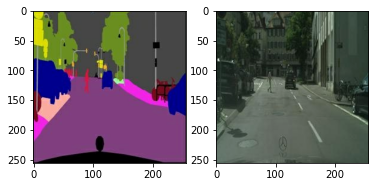

In [27]:
# 先展示一下图像（需要注意的是dataset.take(1)这里代表的是取一个batch的数据）
for mask, img in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    # 这里使用tf.keras.preprocessing.image.array_to_img是因为到这里mask和image已经归一化了，存在你显示不正常的情况
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))

In [28]:
# 上面训练数据加载完毕之后开始加载测试数据
test_images_path = '../../cityscapes_data/cityscapes_data/val/*jpg'
test_images_path_list = glob.glob(pathname=test_images_path)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images_path_list)

In [29]:
# 定义测试图像加载函数
def load_image_test(image_path):
    image = read_jpg(image_path)
    width = tf.shape(image)[1]
    # 由于image和它对应的mask是合并到一张图片的，因此需要从中间切分开来
    width = width // 2
    input_mask = image[:, width:, :]
    input_image = image[:, :width, :]
    
    # 下面两个resize的操作实际上没有什么实质性的影响，因为mask和image本身就是[256, 256, 3]的
    # 但是下面这两个操作能够使得mask和image在做成datasets之后可以正常显示两个的shape大小
    input_mask = tf.image.resize(input_mask, (256, 256))
    input_image = tf.image.resize(input_image, (256, 256))
    
    input_mask, input_image = normalize(input_mask, input_image)
    return input_mask, input_image

In [31]:
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(16)

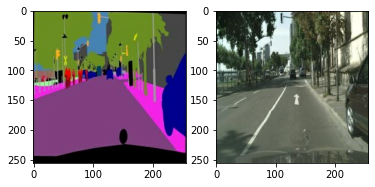

In [32]:
# 先展示一下图像（需要注意的是dataset.take(1)这里代表的是取一个batch的数据）
for mask, img in test_dataset.take(1):
    plt.subplot(1, 2, 1)
    # 这里使用tf.keras.preprocessing.image.array_to_img是因为到这里mask和image已经归一化了，存在你显示不正常的情况
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))

## 2. 定义上采用和下采样模型

In [36]:
def down_sampling(filters, kernel_size, apply_bn_flag=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,                                           strides=2, padding='same', use_bias=False))
    if apply_bn_flag:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    return model

In [37]:
def up_sampling(filters, kernel_size, apply_dropout_flag=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters=filters,                                                                    kernel_size=kernel_size, 
                                              strides=2, padding='same',                                                          use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    if apply_dropout_flag:
        # 添加dropout是为了增加图像的多样性
        model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.ReLU())
    return model

In [41]:
# 定义Generator模型(U-Net架构)
def Generator_model():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    down_stach = [# [256, 256, 3] ===> [128, 128, 64]
                  down_sampling(filters=64, kernel_size=3, apply_bn_flag=False),
                  # [128, 128, 64] ===> [64, 64, 128]
                  down_sampling(filters=128, kernel_size=3),
                  # [64, 64, 128] ===> [32, 32, 256]
                  down_sampling(filters=256, kernel_size=3),
                  # [32, 32, 256] ===> [16, 16, 512]
                  down_sampling(filters=512, kernel_size=3),
                  # [16, 16, 512] ===> [8, 8, 512]
                  down_sampling(filters=512, kernel_size=3),
                  # [8, 8, 512] ===> [4, 4, 512]
                  down_sampling(filters=512, kernel_size=3),
                  # [4, 4, 512] ===> [2, 2, 512]
                  down_sampling(filters=512, kernel_size=3),
                  # [2, 2, 512] ===> [1, 1, 512]
                  down_sampling(filters=512, kernel_size=3)]
    
    up_stach = [# [1, 1, 512] ===> [2, 2, 512]
                up_sampling(filters=512, kernel_size=3, apply_dropout_flag=True),
                # [2, 2, 512] ===> [4, 4, 512]
                up_sampling(filters=512, kernel_size=3, apply_dropout_flag=True),
                # [4, 4, 512] ===> [8, 8, 512]
                up_sampling(filters=512, kernel_size=3, apply_dropout_flag=True),
                # [8, 8, 512] ===> [16, 16, 512]
                up_sampling(filters=512, kernel_size=3),
                
                # [16, 16, 512] ===> [32, 32, 256]
                up_sampling(filters=256, kernel_size=3),
                # [32, 32, 256] ===> [64, 64, 128]
                up_sampling(filters=128, kernel_size=3),
                # [64, 64, 128] ===> [128, 128, 64]
                up_sampling(filters=64, kernel_size=3)]
    
    x = inputs
    skips = []
    for down in down_stach:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stach, skips):
        x = up(x)
        # 使用concatenate增加channel维度
        x = tf.keras.layers.concatenate([x, skip])
        
    # 由于图片的预处理中，对图片进行了[-1, 1]区间的归一化处理，因此使用activation='tanh'
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, 
                                        padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [44]:
def Discriminator_model():
    # D输入的是两张图像，从而判断两张图像是否是成对的图像
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    targets = tf.keras.layers.Input(shape=(256, 256, 3))
    
    # [256, 256, 6]
    x = tf.keras.layers.concatenate([inputs, targets]) 
    # [128, 128, 64]
    x = down_sampling(filters=64, kernel_size=4, apply_bn_flag=False)(x) 
    x = down_sampling(filters=128, kernel_size=4)(x) # [64, 64, 128]
    x = down_sampling(filters=256, kernel_size=4)(x) # [32, 32, 256]
    # [31, 31, 512]
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=4, strides=1, 
                               padding='same', use_bias=False)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # [30, 30, 512]
    x = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1)(x) 
    return tf.keras.Model(inputs=[inputs, targets], outputs=x)

In [48]:
generator = Generator_model()
discriminator = Discriminator_model()

# tf.keras.utils.plot_model(discriminator, show_shapes=True)
# generator.summary()

## 3. 定义损失函数

In [51]:
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [52]:
Lambda = 10
def generator_loss(d_fake_output, gen_output, target):
    gen_loss = loss_func(y_true=tf.ones_like(d_fake_output), y_pred=d_fake_output)
    l1_loss = tf.reduce_mean(tf.abs(gen_output-target))
    return gen_loss + Lambda * l1_loss

def discriminator_loss(d_real_output, d_fake_output):
    real_loss = loss_func(y_true=tf.ones_like(d_real_output), y_pred=d_real_output)
    fake_loss = loss_func(y_true=tf.zeros_like(d_fake_output), y_pred=d_fake_output)
    return real_loss + fake_loss

In [53]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [55]:
def plot_generated_images(model, test_inputs, tar):
    predition = model(test_inputs, training=True)
    plt.figure(figsize=(15, 15))
    
    display_list = [test_inputs[0], tar[0], predition[0]]
    titles = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

### 4. 定义梯度更新函数

In [56]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output],                                                           training=True)

        gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

### 7. 定义模型训练函数

In [57]:
def train(train_ds, epochs, test_ds):
    for epoch in range(epochs+1):
        if epoch%10 == 0:
            for example_input, example_target in test_dataset.take(1):
                plot_generated_images(generator, example_input, example_target)
        print("Now epoch is: ", epoch)

        for n, (input_image, target) in train_dataset.enumerate():
            print('.', end='')
            train_step(input_image, target, epoch)
        print()

In [ ]:
train(train_dataset, EPOCHS, test_dataset)